# K Nearest Neighbors Demo

*Matt Grasser, 11 Sept 2017*

The following notebook includes a walkthrough of the KNN demonstration from Matt Kirk's Thoughtful ML in Python. His repo including data and other supplementary files can be found [here](https://github.com/thoughtfulml/examples-in-python/blob/master/k-nearest-neighbors/data/king_county_data_geocoded.csv).

In [1]:
%matplotlib inline

In [2]:
import random
import sys

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.spatial import KDTree
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
# KDTree will throw an error unless this is set higher
sys.setrecursionlimit(10000)

In [4]:
class Regression:
    """A class for performing K nearest neighbors regression and calculating error rates on a data set"""
    
    def __init__(self, csv_file=None, data=None, values=None):
        """Create an instance of the Regression class"""
        # Read data
        if data is None and csv_file is not None:
            # Read file
            df = pd.read_csv(csv_file)
            
            # Split into input variables and objective
            self.values = df['AppraisedValue']
            df = df.drop('AppraisedValue', 1)
            
            # Normalize input variables to avoid skewing results
            df = (df-df.mean()) / (df.max() - df.min())
            
            # Set up the dataframe we'll work with using only the relevant columns
            self.df = df
            self.df = self.df[['lat', 'long', 'SqFtLot']]
        elif data is not None and values is not None:
            self.df = data
            self.values = values
        else:
            raise ValueError("Must have either csv_file or data set")
            
        # Set up algorithmic params and functions
        self.n = len(self.df)
        self.kdtree = KDTree(self.df)
        self.metric = np.mean
        self.k = 5
    
    def regress(self, query_point):
        """Run the actual regression as defined by the self.metric function"""
        # Get closest `k` neighbors
        distances, indexes = self.kdtree.query(query_point, self.k)
        
        # Calculate the metric based on those neighbors and return it
        m = self.metric(self.values.iloc[indexes])
        if np.isnan(m):
            # zomg
            pass
        else:
            return m
    
    def error_rate(self, folds):
        """Calculate the error rate in model on a test ('holdout') data set"""
        holdout = 1 / float(folds)
        errors = []
        for fold in range(folds):
            y_hat, y_true = self.__validation_data(holdout)
            errors.append(mean_absolute_error(y_true, y_hat))
        return errors
    
    def __validation_data(self, holdout):
        """Split data into training and test sets, run regression, return derived and actual y values"""
        # Calculate Indexes
        test_rows = random.sample(self.df.index, int(round(len(self.df) * holdout)))
        train_rows = set(range(len(self.df))) - set(test_rows)
        
        # Split the data set into training/test variables and objectives
        df_test = self.df.ix[test_rows]
        df_train = self.df.drop(test_rows)
        test_values = self.values.ix[test_rows]
        train_values = self.values.ix[train_rows]
        
        # Perform regression
        kd = Regression(data=df_train, values=train_values)
        y_hat = []
        y_actual = []
        for idx, row in df_test.iterrows():
            y_hat.append(kd.regress(row))
            y_actual.append(self.values[idx])
        
        return (y_hat, y_actual)
    
    def plot_error_rates(self):
        """Plot the error rates for different fold counts"""
        folds = range(2, 11)
        errors = pd.DataFrame({'max':0, 'min':0}, index=folds)
        for f in folds:
            error_rates = self.error_rate(f)
            errors['max'][f] = max(error_rates)
            errors['min'][f] = min(error_rates)
        errors.plot(title="Mean Absolute Error of KNN over different folds")
        plt.show()

In [5]:
r = Regression('data/king_county_data_geocoded.csv')

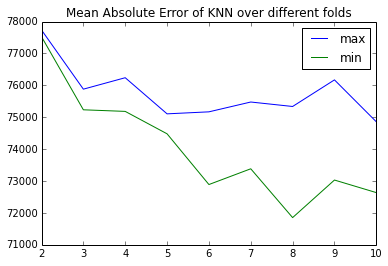

In [6]:
r.plot_error_rates()